In [1]:
!wget --header="Host: datahack-prod.s3.amazonaws.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.83 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://datahack.analyticsvidhya.com/" "https://datahack-prod.s3.amazonaws.com/train_file/Train_hMYJ020.zip" -c -O 'train_data.zip'
!wget --header="Host: datahack-prod.s3.amazonaws.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.83 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://datahack.analyticsvidhya.com/" "https://datahack-prod.s3.amazonaws.com/test_file/Test_ND2Q3bm.zip" -c -O 'Test.zip'
!wget --header="Host: datahack-prod.s3.amazonaws.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.83 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://datahack.analyticsvidhya.com/" "https://datahack-prod.s3.amazonaws.com/sample_submission/sample_submission_lfbv3c3.csv" -c -O 'sample_submission.csv'

--2020-09-06 15:51:00--  https://datahack-prod.s3.amazonaws.com/train_file/Train_hMYJ020.zip
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.64.84
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.64.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4466801 (4.3M) [application/zip]
Saving to: ‘train_data.zip’

train_data.zip      100%[===================>]   4.26M  2.53MB/s    in 1.7s    

2020-09-06 15:51:03 (2.53 MB/s) - ‘train_data.zip’ saved [4466801/4466801]

--2020-09-06 15:51:03--  https://datahack-prod.s3.amazonaws.com/test_file/Test_ND2Q3bm.zip
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.66.36
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.66.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1804568 (1.7M) [application/zip]
Saving to: ‘Test.zip’

Test.zip            100%[======

In [2]:
!unzip train_data.zip
!unzip Test.zip

Archive:  train_data.zip
  inflating: train_data_dict.csv     
   creating: __MACOSX/
  inflating: __MACOSX/._train_data_dict.csv  
  inflating: train.csv               
  inflating: __MACOSX/._train.csv    
Archive:  Test.zip
  inflating: test.csv                
  inflating: __MACOSX/._test.csv     


In [3]:
!pip install catboost

     |████████████████████████████████| 66.1MB 84kB/s 


In [4]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold , StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [53]:
train = pd.read_csv("train.csv")
train['is_train'] = 1
test = pd.read_csv("test.csv")
test['is_train'] = 0
sample = pd.read_csv("sample_submission.csv")

merge = pd.concat([train,test]).reset_index(drop=True)

city_code_max = max(merge["City_Code_Patient"])
bed_grade_max = max(merge["Bed Grade"])

merge["City_Code_Patient"] = merge["City_Code_Patient"].fillna(city_code_max + 1)
merge["Bed Grade"] = merge["Bed Grade"].fillna(bed_grade_max + 1)

merge["City_Code_Patient"] = merge["City_Code_Patient"].apply(lambda x: int(x))
merge["Bed Grade"] = merge["Bed Grade"].apply(lambda x: int(x))

uniques = pd.DataFrame(merge.drop(['Stay','is_train'],axis=1).nunique())
cat_columns = uniques[uniques[0] < 50].index.values.tolist()
cat_columns.remove("Available Extra Rooms in Hospital")

merge = merge[~merge['Available Extra Rooms in Hospital'].isin([14,20,24])]

for i in ['Hospital_type_code', "Hospital_region_code", "Department", "Ward_Type", 'Ward_Facility_Code', "Type of Admission", "Severity of Illness", "Age"]:
  merge[i] = pd.factorize(merge[i])[0]

#########
from tqdm import tqdm_notebook as tqdm

useful_combs = [['Ward_Type','Visitors with Patient'],
                ['Ward_Type','Bed Grade'],
                ['Bed Grade', 'Severity of Illness'],
                ['Hospital_code', 'City_Code_Patient'],
                ['City_Code_Hospital', 'City_Code_Patient'],
                ['Bed Grade', 'Type of Admission'],
                ['Severity of Illness', 'Age'],
                ['Hospital_region_code', 'Ward_Type'],
                ['Type of Admission', 'Visitors with Patient'],
                ['Ward_Type', 'Ward_Facility_Code'],
                ['Hospital_code', 'Visitors with Patient'],
                ['Type of Admission', 'Age'],
                ['Ward_Type', 'Type of Admission'],
                ['Severity of Illness', 'Visitors with Patient'],
                ['City_Code_Hospital', 'Ward_Type'],
                ['Department', 'Ward_Type'],
                ['Visitors with Patient', 'Age'],
                ['Hospital_code', 'Type of Admission'],
                ['Bed Grade', 'Age'],
                ['Department', 'Severity of Illness'],
                ['Department', 'Visitors with Patient'],
                ['City_Code_Hospital', 'Visitors with Patient'],
                ['Hospital_region_code', 'Age'],
                ['Bed Grade', 'Visitors with Patient'],
                ['Hospital_code', 'Department'],
                ['Hospital_code', 'Severity of Illness'],
                ['Hospital_region_code', 'Bed Grade']]

for comb in tqdm(useful_combs):
  one,two = comb
  name = f'{one}__{two}'
  # merge[name] = merge.apply(lambda x:str(x[one]) +"_"+str(x[two]),axis=1)
  merge[name] = merge[one].astype(str) + "_" + merge[two].astype(str)

  merge[name] = pd.factorize(merge[name])[0]  
  if len(np.unique(merge[name])) < 50:
    cat_columns.append(name)

# for f in cat_columns:
#   merge[f] = merge[f].map(merge[f].value_counts(normalize = True))
  
one,two = 'Ward_Type','Visitors with Patient'
m = merge.groupby([one])[two].agg(['mean','std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","std":f"{one}_{two}_std"})
merge = merge.merge(m,on=[one],how="left")

one,two = 'patientid','Visitors with Patient'
m = merge.groupby([one])[two].agg(['mean','sum',"max"])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = 'Age','Visitors with Patient'
m = merge.groupby([one])[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = 'Hospital_code','Visitors with Patient'
m = merge.groupby([one])[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = 'Hospital_type_code','Visitors with Patient'
m = merge.groupby([one])[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = 'Type of Admission','Visitors with Patient'
m = merge.groupby([one])[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = 'City_Code_Patient','Visitors with Patient'
m = merge.groupby([one])[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = 'City_Code_Hospital','Visitors with Patient'
m = merge.groupby([one])[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = ['Hospital_code','Ward_Type'],'Visitors with Patient'
m = merge.groupby(one)[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=one,how="left")




one,two = 'Hospital_code','Available Extra Rooms in Hospital'
m = merge.groupby([one])[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = 'City_Code_Hospital','Available Extra Rooms in Hospital'
m = merge.groupby([one])[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = 'Ward_Type','Available Extra Rooms in Hospital'
m = merge.groupby([one])[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = 'Department','Available Extra Rooms in Hospital'
m = merge.groupby(one)[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=one,how="left")

one,two = 'patientid','Available Extra Rooms in Hospital'
m = merge.groupby(one)[two].agg(['mean','sum',"max"])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=one,how="left")

one,two = 'City_Code_Patient','Available Extra Rooms in Hospital'
m = merge.groupby(one)[two].agg(['mean','sum',"max"])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=one,how="left")

one,two = 'Ward_Type__Visitors with Patient','Available Extra Rooms in Hospital'
m = merge.groupby(one)[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=one,how="left")





one,two = 'Hospital_code','Admission_Deposit'
m = merge.groupby([one])[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = 'patientid','Admission_Deposit'
m = merge.groupby([one])[two].agg(['mean','sum',"max"])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=[one],how="left")

one,two = ['Visitors with Patient'],'Admission_Deposit'
m = merge.groupby(one)[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=one,how="left")

one,two = ['Hospital_code','Department'],'Admission_Deposit'
m = merge.groupby(one)[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=one,how="left")

one,two = 'Age','Admission_Deposit'
m = merge.groupby(one)[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=one,how="left")

one,two = 'Department','Admission_Deposit'
m = merge.groupby(one)[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=one,how="left")

one,two = 'Ward_Type__Visitors with Patient','Admission_Deposit'
m = merge.groupby(one)[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum",
                      "std":f"{one}_{two}_std","max":f"{one}_{two}_max"})
merge = merge.merge(m,on=one,how="left")



c = ['Hospital_code','Hospital_type_code',
     'City_Code_Hospital',"Hospital_region_code",'Department',
     'Ward_Type','Type of Admission','Age']

from itertools import combinations
for comb in tqdm(combinations(c,2)):
  one,two = comb
  m = merge.groupby([one])[two].agg(['nunique','count'])
  m = m.rename(columns={"nunique":f"{one}_{two}_nunique","count":f"{one}_{two}_count"})
  merge = merge.merge(m,on=[one],how="left")





# one,two = 'City_Code_Hospital','patientid'
# m = merge.groupby([one])[two].agg(['nunique','count'])
# m = m.rename(columns={"nunique":f"{one}_{two}_nunique","count":f"{one}_{two}_count"})
# merge = merge.merge(m,on=[one],how="left")

# one,two = 'City_Code_Hospital','Hospital_code'
# m = merge.groupby([one])[two].agg(['nunique','count'])
# m = m.rename(columns={"nunique":f"{one}_{two}_nunique","count":f"{one}_{two}_count"})
# merge = merge.merge(m,on=[one],how="left")

# one,two = 'Hospital_code','Ward_Type'
# m = merge.groupby([one])[two].agg(['nunique','count'])
# m = m.rename(columns={"nunique":f"{one}_{two}_nunique","count":f"{one}_{two}_count"})
# merge = merge.merge(m,on=[one],how="left")

# one,two = 'Hospital_type_code','Hospital_code'
# m = merge.groupby([one])[two].agg(['count'])
# m = m.rename(columns={"nunique":f"{one}_{two}_nunique","count":f"{one}_{two}_count"})
# merge = merge.merge(m,on=[one],how="left")

# one,two = 'Age','patientid'
# m = merge.groupby([one])[two].agg(['nunique','count'])
# m = m.rename(columns={"nunique":f"{one}_{two}_nunique","count":f"{one}_{two}_count"})
# merge = merge.merge(m,on=[one],how="left")

# one,two = 'Hospital_code','patientid'
# m = merge.groupby([one])[two].agg(['nunique','count'])
# m = m.rename(columns={"nunique":f"{one}_{two}_nunique","count":f"{one}_{two}_count"})
# merge = merge.merge(m,on=[one],how="left")

# one,two = 'City_Code_Patient','patientid'
# m = merge.groupby([one])[two].agg(['nunique','count'])
# m = m.rename(columns={"nunique":f"{one}_{two}_nunique","count":f"{one}_{two}_count"})
# merge = merge.merge(m,on=[one],how="left")


#########
train = merge[merge.is_train == 1]
test = merge[merge.is_train == 0]
train.drop(["is_train",'case_id'],axis=1,inplace=True)
test.drop(["is_train",'Stay'],axis=1,inplace=True)

merge

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,is_train,Ward_Type__Visitors with Patient,Ward_Type__Bed Grade,Bed Grade__Severity of Illness,Hospital_code__City_Code_Patient,City_Code_Hospital__City_Code_Patient,Bed Grade__Type of Admission,Severity of Illness__Age,Hospital_region_code__Ward_Type,Type of Admission__Visitors with Patient,Ward_Type__Ward_Facility_Code,Hospital_code__Visitors with Patient,Type of Admission__Age,Ward_Type__Type of Admission,Severity of Illness__Visitors with Patient,City_Code_Hospital__Ward_Type,Department__Ward_Type,Visitors with Patient__Age,Hospital_code__Type of Admission,Bed Grade__Age,Department__Severity of Illness,Department__Visitors with Patient,...,Hospital_type_code_Hospital_region_code_nunique,Hospital_type_code_Hospital_region_code_count,Hospital_type_code_Department_nunique,Hospital_type_code_Department_count,Hospital_type_code_Ward_Type_nunique,Hospital_type_code_Ward_Type_count,Hospital_type_code_Type of Admission_nunique,Hospital_type_code_Type of Admission_count,Hospital_type_code_Age_nunique,Hospital_type_code_Age_count,City_Code_Hospital_Hospital_region_code_nunique,City_Code_Hospital_Hospital_region_code_count,City_Code_Hospital_Department_nunique,City_Code_Hospital_Department_count,City_Code_Hospital_Ward_Type_nunique,City_Code_Hospital_Ward_Type_count,City_Code_Hospital_Type of Admission_nunique,City_Code_Hospital_Type of Admission_count,City_Code_Hospital_Age_nunique,City_Code_Hospital_Age_count,Hospital_region_code_Department_nunique,Hospital_region_code_Department_count,Hospital_region_code_Ward_Type_nunique,Hospital_region_code_Ward_Type_count,Hospital_region_code_Type of Admission_nunique,Hospital_region_code_Type of Admission_count,Hospital_region_code_Age_nunique,Hospital_region_code_Age_count,Department_Ward_Type_nunique,Department_Ward_Type_count,Department_Type of Admission_nunique,Department_Type of Admission_count,Department_Age_nunique,Department_Age_count,Ward_Type_Type of Admission_nunique,Ward_Type_Type of Admission_count,Ward_Type_Age_nunique,Ward_Type_Age_count,Type of Admission_Age_nunique,Type of Admission_Age_count
0,1,8,0,3,0,3,0,0,0,2,31397,7,0,0,2,0,4911.0,0-10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,66147,5,66147,5,66147,3,66147,10,66147,1,45544,5,45544,5,45544,3,45544,10,45544,5,89939,5,89939,3,89939,10,89939,5,41031,3,41031,10,41031,3,182936,10,182936,10,168362
1,2,2,0,5,0,2,0,1,0,2,31397,7,1,0,2,0,5954.0,41-50,1,1,1,0,1,1,1,0,1,1,1,1,1,1,0,1,1,0,1,0,0,0,...,1,66147,5,66147,5,66147,3,66147,10,66147,1,44395,5,44395,4,44395,3,44395,10,44395,5,89939,5,89939,3,89939,10,89939,5,41031,3,41031,10,41031,3,111165,10,111165,10,217669
2,3,10,1,1,1,2,1,1,1,2,31397,7,1,0,2,0,4745.0,31-40,1,1,1,0,2,2,1,0,2,1,2,2,1,1,0,2,2,0,2,0,1,1,...,1,35428,5,35428,3,35428,3,35428,10,35428,1,79058,5,79058,4,79058,3,79058,10,79058,5,190849,4,190849,3,190849,10,190849,5,42357,3,42357,10,42357,3,111165,10,111165,10,217669
3,4,26,2,2,2,2,0,0,2,2,31397,7,1,0,2,0,7272.0,41-50,1,0,0,0,3,3,1,0,3,1,3,3,1,2,0,3,0,0,3,0,0,0,...,2,98882,5,98882,4,98882,3,98882,10,98882,1,74310,5,74310,4,74310,3,74310,10,74310,5,174703,5,174703,3,174703,10,174703,5,41031,3,41031,10,41031,3,182936,10,182936,10,217669
4,5,26,2,2,2,2,0,1,2,2,31397,7,1,0,2,0,5558.0,41-50,1,1,1,0,3,3,1,0,4,1,4,3,1,1,0,4,1,0,3,0,0,0,...,2,98882,5,98882,4,98882,3,98882,10,98882,1,74310,5,74310,4,74310,3,74310,10,74310,5,174703,5,174703,3,174703,10,174703,5,41031,3,41031,10,41031,3,111165,10,111165,10,217669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [54]:
# uniques = 
# pd.DataFrame(merge.drop(['Stay','is_train'],axis=1).nunique())
test.isna().sum()
# merge.columns
# pd.DataFrame(merge.drop(['Stay','is_train'],axis=1).nunique())
# cat_columns

case_id                              0
Hospital_code                        0
Hospital_type_code                   0
City_Code_Hospital                   0
Hospital_region_code                 0
                                    ..
Ward_Type_Type of Admission_count    0
Ward_Type_Age_nunique                0
Ward_Type_Age_count                  0
Type of Admission_Age_nunique        0
Type of Admission_Age_count          0
Length: 186, dtype: int64

In [55]:
one,two = 'Age','Visitors with Patient'
m = merge.groupby([one])[two].agg(['mean','sum',"max",'std'])
m = m.rename(columns={"mean":f"{one}_{two}_mean","sum":f"{one}_{two}_sum","min":f"{one}_{two}_min","max":f"{one}_{two}_max"})
m
# # sns.jointplot(x=one,y=two,data=train,kind="kde")
# # plt.show()
# # sns.jointplot(x=one,y=two,data=test,kind="kde")
# one,two = 'Hospital_code','Age'
# m = pd.DataFrame(merge.groupby(one)[two].value_counts()).unstack().reset_index()
# m.columns = [f"{one}_" + '_'.join([str(j) for j in i]).strip("_") + "_count" for i in m.columns]
# # merge = merge.merge(m,on=[one],how="left")
# m

,Age_Visitors with Patient_mean,Age_Visitors with Patient_sum,Age_Visitors with Patient_max,std
Age,,,,
0,3.546191,246478,32,1.932125
1,3.356335,170287,32,1.867150
2,3.073712,277925,24,1.619884
3,3.323529,304083,24,1.706601
4,3.393861,38147,32,1.884166
5,3.486034,169484,29,1.894957
6,3.028808,177367,24,1.590233
7,3.107494,74179,24,1.559545
8,3.407221,31142,24,1.946329


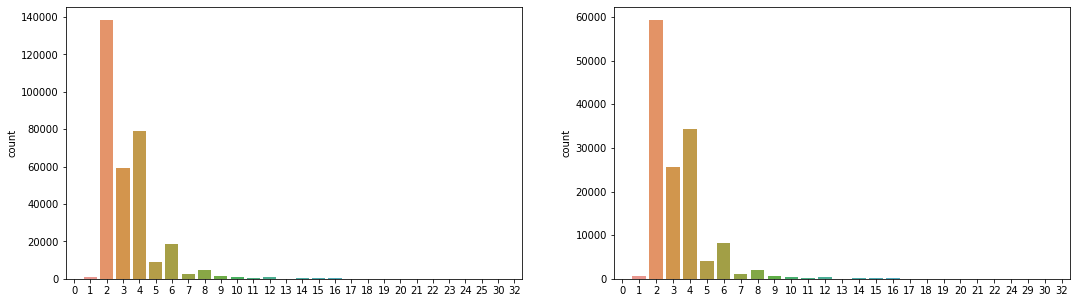

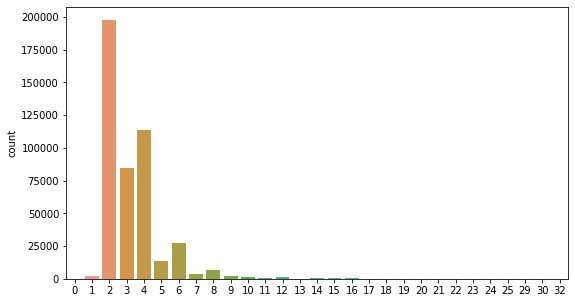

In [56]:
# col = "Available Extra Rooms in Hospital"
# train mein 14 20 24 extra hain ( Done )

# col = "patientid"

# col = "Visitors with Patient"
# train mein 25 hai lekin test mein 29

col = "Visitors with Patient"
fig,ax = plt.subplots(1,2,figsize=(18,5))

sns.countplot(sorted(train[col]),ax=ax[0])
sns.countplot(sorted(test[col]),ax=ax[1])
plt.show()

plt.figure(figsize=(9,5))
sns.countplot(sorted(merge[col]))

0:	learn: 0.3236898	test: 0.3251370	best: 0.3251370 (0)	total: 37.6ms	remaining: 15m 38s
200:	learn: 0.4199971	test: 0.4186883	best: 0.4187511 (197)	total: 6.48s	remaining: 13m 19s
400:	learn: 0.4274476	test: 0.4239484	best: 0.4240740 (396)	total: 12.9s	remaining: 13m 10s
600:	learn: 0.4319698	test: 0.4266962	best: 0.4267590 (599)	total: 19.2s	remaining: 13m 1s
800:	learn: 0.4358363	test: 0.4278738	best: 0.4280465 (791)	total: 25.6s	remaining: 12m 52s
1000:	learn: 0.4384193	test: 0.4293812	best: 0.4293969 (986)	total: 31.9s	remaining: 12m 45s
1200:	learn: 0.4412103	test: 0.4301977	best: 0.4301977 (1197)	total: 38.2s	remaining: 12m 36s
1400:	learn: 0.4435185	test: 0.4308415	best: 0.4310456 (1397)	total: 44.4s	remaining: 12m 28s
1600:	learn: 0.4456147	test: 0.4312340	best: 0.4314852 (1549)	total: 50.6s	remaining: 12m 19s
1800:	learn: 0.4476952	test: 0.4316737	best: 0.4317365 (1764)	total: 56.7s	remaining: 12m 10s
2000:	learn: 0.4497168	test: 0.4318307	best: 0.4320819 (1963)	total: 1m 2s	

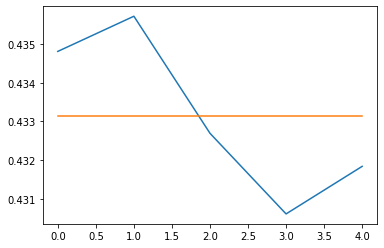

In [60]:
X = train.drop(["Stay"],axis=1)
Y = train[['Stay']]

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Y_ = encoder.fit_transform(Y)
Y['Stay'] = Y_

params = {
    "od_type":"Iter",
    "od_wait":150,
    "iterations":25000,
    'learning_rate':0.0224,
    "eval_metric":"Accuracy",
    "task_type":"GPU",
    # "boosting_type":"Plain"
}


def work(X,Y):
  final_preds = []
  best_score = 0
  scores = []

  folds = KFold(n_splits=5,shuffle=True,random_state=1250)

  for train_idx , test_idx in folds.split(X,Y):
    train_set = (X.iloc[train_idx],Y.iloc[train_idx])
    test_set = (X.iloc[test_idx],Y.iloc[test_idx])

    model = CatBoostClassifier(**params)
    model.fit(*train_set,
              cat_features = cat_columns,
              eval_set=[test_set],early_stopping_rounds=500,verbose=200)

    score = accuracy_score(test_set[1].values,model.predict(test_set[0]))
    print(score)
    scores.append(score)

    if score > best_score:
      best_score = score
      best_model = model

    print("---"*50)

    if final_preds == []:
      final_preds = model.predict_proba(test.drop('case_id',axis=1))
    else:
      final_preds += model.predict_proba(test.drop('case_id',axis=1))
  
  print(f"Mean Score : {np.array(scores).mean()}")
  print(f"Min Score : {np.array(scores).min()}")
  print(f"Max Score : {np.array(scores).max()}")

  plt.plot(scores)
  plt.plot(np.arange(len(scores)),[np.array(scores).mean()]*len(scores),)
  plt.show()

  final_preds /= 5
  return best_model , final_preds

model,preds = work(X,Y)
preds = encoder.inverse_transform(np.argmax(preds,axis=1))

In [61]:
pd.set_option("display.max_colwidth",100)
pd.set_option("display.max_rows",150)
m = pd.DataFrame(list(zip(X.columns,model.feature_importances_))).sort_values(1,ascending=False)
m
# x = m[(m[1] < 1) & (m[1] > 0.8)][0].values.tolist()
# [i.split("__") for i in x if len(i.split("__")) == 2]

,0,1
125,Ward_Type__Visitors with Patient_Admission_Deposit_mean,8.020393
128,Ward_Type__Visitors with Patient_Admission_Deposit_std,5.583059
15,Admission_Deposit,4.450615
108,patientid_Admission_Deposit_max,2.647029
45,patientid_Visitors with Patient_mean,2.598310
...,...,...
141,Hospital_code_Age_nunique,0.000000
133,Hospital_code_Hospital_region_code_nunique,0.000000
131,Hospital_code_City_Code_Hospital_nunique,0.000000
129,Hospital_code_Hospital_type_code_nunique,0.000000


In [62]:
preds

array(['0-10', '51-60', '21-30', ..., '21-30', '11-20', '51-60'],
      dtype=object)

In [64]:
# preds = model.predict(test.drop('case_id',axis=1))
# preds = model.predict(test[cols])
testing = test.copy()
testing['Stay'] = preds
# x = pd.read_csv("submission.csv")
submission = testing[['case_id',"Stay"]]
submission.to_csv("submission.csv",index=False)
submission

,case_id,Stay
318434,318439,0-10
318435,318440,51-60
318436,318441,21-30
318437,318442,21-30
318438,318443,51-60
...,...,...
455486,455491,21-30
455487,455492,0-10
455488,455493,21-30
455489,455494,11-20


In [110]:
x['Stay'] = preds
x.to_csv("submission.csv",index=False)
x

,case_id,Stay
0,318439,0-10
1,318440,51-60
2,318441,21-30
3,318442,21-30
4,318443,51-60
...,...,...
137052,455491,21-30
137053,455492,0-10
137054,455493,21-30
137055,455494,11-20
